In [37]:
import os
import numpy as np
#Suppress Warning
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.layers import GRU, LSTM, Input, Dense
from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
import pandas as pd

In [38]:
class Model_Custom:
    def __init__(self, num_features, time_steps, LSTM_units, GRU_units):     

        self.t = time_steps
        self.n = num_features

        inp =  Input(shape=(time_steps, num_features))

        LSTM_layer = LSTM(units=LSTM_units,return_sequences = True, return_state = True)

        Out_sequence, H, C = LSTM_layer(inp)

        GRU_layer = GRU(units = GRU_units)

        output_=GRU_layer(Out_sequence , initial_state=C)

        output = Dense(1)(output_)

        

        self.my_model =  Model(inp,output)
        self.my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def summary(self):
        self.my_model.build((None, self.t, self.n))
        return self.my_model.summary()

    def fit(self, X, y, epochs=5, batch_size=16):
        return self.my_model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, X):
        return self.my_model.predict(X)

In [39]:
df = pd.read_csv('compiled_dataset.csv', parse_dates=['Date'])

features = [
    "Date",
    'dow_jones_adj_close_price',
    'nasdaq_adj_close_price',
    'sp_adj_close_price',
    'usd_to_uk_exchange_rate',
    'treasury_1_year_rate',
    'treasury_10_year_rate',
    'breakeven_inflation_5_year_rate',
    'breakeven_inflation_10_year_rate',
    'bank_prime_loan_rate',
    'federal_funds_rate',
]

target = 'cushing_crude_oil_price'

data = df[features + [target]]
#print(data)
data.set_index("Date", inplace= True)
data = data.resample('D').mean()
data = data.interpolate()

In [40]:
data

,dow_jones_adj_close_price,nasdaq_adj_close_price,sp_adj_close_price,usd_to_uk_exchange_rate,treasury_1_year_rate,treasury_10_year_rate,breakeven_inflation_5_year_rate,breakeven_inflation_10_year_rate,bank_prime_loan_rate,federal_funds_rate,cushing_crude_oil_price
Date,,,,,,,,,,,
2003-01-16,9.070833,7.261050,6.818487,1.607300,1.36,4.05,1.400000,1.790000,4.25,1.24,3.516310
2003-01-17,9.057974,7.227074,6.804371,1.617300,1.36,4.05,1.450000,1.800000,4.25,1.24,3.523710
2003-01-18,9.053751,7.224896,6.800414,1.616050,1.36,4.05,1.432500,1.795000,4.25,1.24,3.528818
2003-01-19,9.049528,7.222717,6.796457,1.614800,1.36,4.05,1.415000,1.790000,4.25,1.24,3.533926
2003-01-20,9.045304,7.220539,6.792500,1.613550,1.36,4.05,1.397500,1.785000,4.25,1.24,3.539034
...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,10.615284,9.781927,8.631261,1.327300,3.95,4.28,2.300000,2.250000,7.50,4.33,4.081597
2025-05-02,10.629040,9.796889,8.645880,1.328300,3.95,4.28,2.310000,2.270000,7.50,4.33,4.065431
2025-05-03,10.628243,9.794405,8.643746,1.328333,3.95,4.28,2.316667,2.273333,7.50,4.33,4.058730


In [41]:
def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])   # predict next day
    return np.array(X_seq), np.array(y_seq)

In [42]:
features.remove("Date")
X_all = data[features].values
y_all = data[target].values


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_all)
y_scaled = scaler_y.fit_transform(y_all.reshape(-1, 1))

In [43]:
time_step = 5
X_seq, y_seq = create_sequences(X_scaled, y_scaled,time_step)

In [44]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [45]:
model = Model_Custom(
    num_features=X_train.shape[2],
    time_steps=time_step,
    LSTM_units=64,
    GRU_units=64
)

model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=16)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 5, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 5, 64),   │     19,200 │ input_layer_3[0]… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 64)        │     24,960 │ lstm_3[0][0],     │
│                     │                   │            │ lstm_3[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ gru_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,225 (172.75 KB)

 Trainable params: 44,225 (172.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.5356e-04 - loss: 0.6323
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5981
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5937
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5906
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 3.0713e-04 - loss: 0.5885
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5867
Epoch 7/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 3.0713e-04 - loss: 0.5859
Epoch 8/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 3.0713e-04 - loss: 0.5849
Epoch 9/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 3.0713e-04 - loss: 0.5840
Epoch 10/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5830
Epoch 11/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 3.0713e-04 - loss: 0.5826
Epoch 12

In [46]:
preds = model.predict(X_test)
from sklearn.metrics import mean_squared_error
print("MSE:", mean_squared_error(y_test, preds))

preds = model.predict(X_train)
print("MSE:", mean_squared_error(y_train, preds))

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
MSE: 0.003993093077272781
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MSE: 0.0011846602318087483


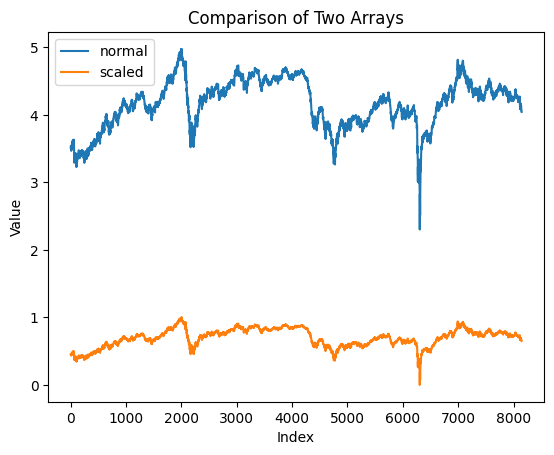

In [51]:
import numpy as np
import matplotlib.pyplot as plt


# Create index for x-axis
x = np.arange(len(y_all))

plt.figure()

# Plot both arrays
plt.plot(x, y_all, label="normal")
plt.plot(x, y_scaled, label="scaled")

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Two Arrays")
plt.legend()
plt.show()


In [53]:
data.loc[data[target] < 0]


,dow_jones_adj_close_price,nasdaq_adj_close_price,sp_adj_close_price,usd_to_uk_exchange_rate,treasury_1_year_rate,treasury_10_year_rate,breakeven_inflation_5_year_rate,breakeven_inflation_10_year_rate,bank_prime_loan_rate,federal_funds_rate,cushing_crude_oil_price
Date,,,,,,,,,,,
